In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 


import pandas as pd
from textblob import TextBlob
import re

import csv
import tweepy
import ssl

In [2]:
#Twitter Authentication with Python

ssl._create_default_https_context = ssl._create_unverified_context
# Oauth keys
consumer_key = "PaMeTokjOgO5DMR1MfcQXsLVl"
consumer_secret = "4wJ65COHFbgLPCzxs0OGIcarAnPxqAwgIwxn3TtjzFjpzOLYPh"
access_token = "3194373019-eR9TOW13vaxNso8TqeQWxMJqb1fkWbN2Vy9q5l9"
access_token_secret = "aMn32tHliAwLKqMRSNrklXtly6CclQ5oY6bJuhFx4RiAM"
# Authentication with Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [5]:
api = tweepy.API(auth, wait_on_rate_limit=True)
# update these for whatever tweet you want to process replies to
name = 'miakhalifa'
target_tweet_id = "1286737814097281024"
 
replies=[]
for tweet in tweepy.Cursor(api.search,q='to:'+name, result_type='recent', timeout=999999).items(1000):
    if hasattr(tweet, 'in_reply_to_status_id_str'):
        if (tweet.in_reply_to_status_id_str==target_tweet_id):
            replies.append(tweet)
 
# update these for whatever tweet you want to process replies to
tweet_pd = pd.DataFrame(replies)

In [6]:
def tweetstoDataFrame(tweets):
 
   DataSet = pd.DataFrame()
 
   DataSet['tweetID'] = [tweet.id for tweet in tweets]
   DataSet['tweetText'] = [tweet.text for tweet in tweets]
   DataSet['Twitter_Name']= [tweet.user.screen_name for tweet in tweets]

   ...
   return DataSet
 
#Pass the tweets list to the above function to create a DataFrame
DataSet = tweetstoDataFrame(replies)

In [9]:
df = DataSet

In [7]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [10]:
# remove twitter handles (@user)
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweetText'], "@[\w]*")

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [12]:
df['scores'] = df['tidy_tweet'].apply(lambda tidy_tweet: sid.polarity_scores(tidy_tweet))

df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

In [14]:
df

,tweetID,tweetText,Twitter_Name,tidy_tweet,scores,compound,sentiment_type
0,1410176751120961544,"@miakhalifa Hi guys, I would recommend a great...",maya22622,"Hi guys, I would recommend a great Solar Ligh...","{'neg': 0.0, 'neu': 0.644, 'pos': 0.356, 'comp...",0.8074,POSITIVE
1,1410167134479687680,"@miakhalifa @miakhalifa, plz help brazil !!! \...",joaopedrosdo,", plz help brazil !!! \n#ForaBolsonaro\n#Impe...","{'neg': 0.0, 'neu': 0.451, 'pos': 0.549, 'comp...",0.5962,POSITIVE
2,1410150955455295494,@miakhalifa Victim mentallity 101 (how not to ...,manymen122,Victim mentallity 101 (how not to take respon...,"{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compou...",-0.5423,NEGATIVE
3,1410150518173933574,@miakhalifa Your pussy is ruined,dejackshon,Your pussy is ruined,"{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'comp...",-0.4767,NEGATIVE
4,1410138536569757696,@miakhalifa 🤩,FajlulK68491467,🤩,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
5,1410129249403478020,@miakhalifa Mesg me in watsapp- +91 8639771283...,RiyaRai05981932,Mesg me in watsapp- +91 8639771283 For paid fun.,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp...",0.5106,POSITIVE
6,1410125096161746948,@miakhalifa Just say no?,jihoon3k,Just say no?,"{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",-0.2960,NEGATIVE
7,1410087582130704387,@miakhalifa Wrong,AndrecharlesC,Wrong,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",-0.4767,NEGATIVE
8,1410058732525006851,@miakhalifa تعالي البحرين اجازه,atalltalal,تعالي البحرين اجازه,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
9,1410055084000661509,@miakhalifa I guess you didn't regret,SaadMulhim,I guess you didn't regret,"{'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'comp...",0.3252,POSITIVE


In [13]:
df.sentiment_type.value_counts()

POSITIVE    10
NEUTRAL      9
NEGATIVE     5
Name: sentiment_type, dtype: int64

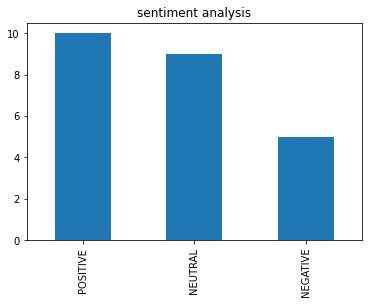

In [15]:
df.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

In [17]:
#sort only negative comments

#del df['tweetText','scores']
df = df.drop(['tweetText', 'scores'], axis = 1)

df = df.drop(df[(df.sentiment_type != 'NEGATIVE')].index)   #positive , neutral

In [18]:
df = df.sort_values('compound')

In [24]:
df

,tweetID,Twitter_Name,tidy_tweet,compound,sentiment_type
2,1410150955455295494,manymen122,Victim mentallity how take responsibility you...,-0.5423,NEGATIVE
3,1410150518173933574,dejackshon,Your pussy ruined,-0.4767,NEGATIVE
7,1410087582130704387,AndrecharlesC,Wrong,-0.4767,NEGATIVE
22,1409858992743014403,SushilSubedi04,What about trauma those guys have been facing ...,-0.4215,NEGATIVE
6,1410125096161746948,jihoon3k,Just,-0.2960,NEGATIVE


In [19]:
from wordcloud import WordCloud

In [20]:
#removing short words and punctuation

df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# remove special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

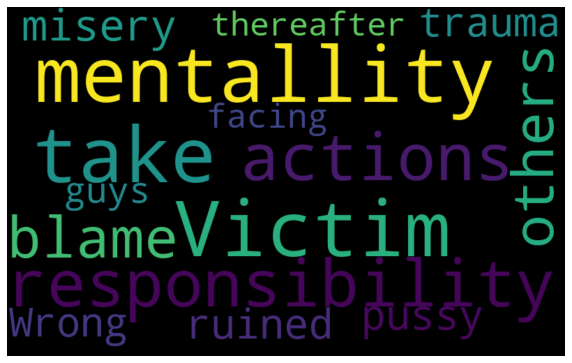

In [23]:
#word cloud

negative_words = ' '.join([text for text in df['tidy_tweet'][df['sentiment_type'] == 'NEGATIVE']])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [26]:
username = 'manymen122'
max_tweets = 150
 
tweets = tweepy.Cursor(api.user_timeline,id=username).items(max_tweets)
 
# Pulling information from tweets iterable object
# Add or remove tweet information you want in the below list comprehension
tweets_list = [[tweet.text, tweet.created_at, tweet.id_str, tweet.user.screen_name,  tweet.retweet_count, tweet.favorite_count, tweet.lang, tweet.source, tweet.in_reply_to_status_id_str, tweet.in_reply_to_user_id_str, tweet.is_quote_status] for tweet in tweets]
 
# Creation of dataframe from tweets_list
# Add or remove columns as you remove tweet information
tweets_df = pd.DataFrame(tweets_list,columns=['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'Twitter @ Name', 'Retweets', 'Favorites', 'Language', 'Source', 'Replied Tweet Id', 'Replied Tweet User Id Str', 'Quote Status Bool'])
 

In [27]:
tweets_df

,Tweet Text,Tweet Datetime,Tweet Id,Twitter @ Name,Retweets,Favorites,Language,Source,Replied Tweet Id,Replied Tweet User Id Str,Quote Status Bool
0,@hmalviya9 @MuroCrypto 👌,2021-06-30 10:00:47,1410176482006142976,manymen122,0,0,und,Twitter for iPhone,1410176080309153795,84375672,False
1,@rrcn97 @SinghArjking8 @miakhalifa Exactly bla...,2021-06-30 08:22:54,1410151846837170176,manymen122,0,1,en,Twitter for iPhone,1286772994271064065,791589524665229312,False
2,@manndaatheresa @miakhalifa U just like to act...,2021-06-30 08:21:35,1410151516766412801,manymen122,0,1,en,Twitter for iPhone,1286745560368676865,1223426997734531072,False
3,@emKaushal @sweetestwonders @miakhalifa Very true,2021-06-30 08:20:02,1410151124468916228,manymen122,0,0,en,Twitter for iPhone,1408531208351322112,3275186124,False
4,@miakhalifa Victim mentallity 101 (how not to ...,2021-06-30 08:19:21,1410150955455295494,manymen122,0,0,en,Twitter for iPhone,1286737814097281024,2835653131,False
...,...,...,...,...,...,...,...,...,...,...,...
145,@GrizzlyDark2 @AlgodTrading That guy called to...,2021-06-05 00:05:06,1400966876717535232,manymen122,0,1,en,Twitter for iPhone,1400870877827198977,1287128162284036096,False
146,@TraderNJ1 @TikTokInvestors is he in your team...,2021-06-05 00:01:02,1400965850828611586,manymen122,0,0,en,Twitter for iPhone,1400926174918942720,918956561216737280,False
147,@TikTokInvestors https://t.co/NbbNRZy6vh,2021-06-05 00:00:08,1400965623832842241,manymen122,0,1,und,Twitter for iPhone,1400965298463952898,1295428909538906115,False
148,@jebus911 Arent you at the peak of your trip ...🤣,2021-06-04 23:52:10,1400963622390665217,manymen122,0,0,en,Twitter for iPhone,1400962939591475200,162573283,False


In [28]:
tweets_df2 = tweets_df

In [29]:
tweets_df2['tidy_tweet'] = np.vectorize(remove_pattern)(tweets_df2['Tweet Text'], "@[\w]*")

In [30]:
tweets_df2['scores'] = tweets_df2['tidy_tweet'].apply(lambda tidy_tweet: sid.polarity_scores(tidy_tweet))

tweets_df2['compound'] = tweets_df2['scores'].apply(lambda score_dict: score_dict['compound'])
tweets_df2['sentiment_type']=''
tweets_df2.loc[tweets_df2.compound>0,'sentiment_type']='POSITIVE'
tweets_df2.loc[tweets_df2.compound==0,'sentiment_type']='NEUTRAL'
tweets_df2.loc[tweets_df2.compound<0,'sentiment_type']='NEGATIVE'


In [31]:
tweets_df2 = tweets_df2.drop(['Tweet Text', 'Source','Language','Quote Status Bool','scores' ], axis = 1)

In [33]:
tweets_df2.head()

,Tweet Datetime,Tweet Id,Twitter @ Name,Retweets,Favorites,Replied Tweet Id,Replied Tweet User Id Str,tidy_tweet,compound,sentiment_type
0,2021-06-30 10:00:47,1410176482006142976,manymen122,0,0,1410176080309153795,84375672,👌,0.0000,NEUTRAL
1,2021-06-30 08:22:54,1410151846837170176,manymen122,0,1,1286772994271064065,791589524665229312,Exactly blaming men for her actions is very...,-0.4939,NEGATIVE
2,2021-06-30 08:21:35,1410151516766412801,manymen122,0,1,1286745560368676865,1223426997734531072,U just like to act like victims and blame me...,0.0772,POSITIVE
3,2021-06-30 08:20:02,1410151124468916228,manymen122,0,0,1408531208351322112,3275186124,Very true,0.4754,POSITIVE
4,2021-06-30 08:19:21,1410150955455295494,manymen122,0,0,1286737814097281024,2835653131,Victim mentallity 101 (how not to take respon...,-0.5423,NEGATIVE


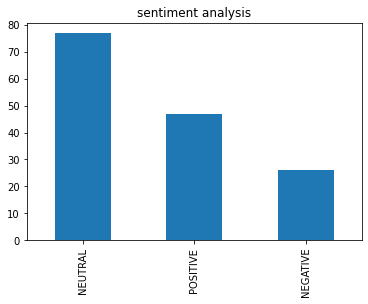

In [34]:
tweets_df2.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")